<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:58:42] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


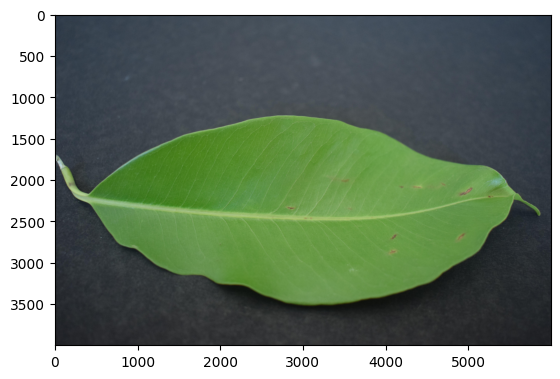

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

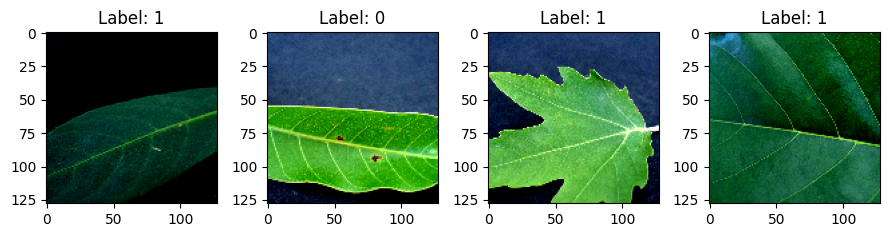

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:58:49] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

[03:58:51] /work/mxnet/src/operator/cudnn_ops.cc:421: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


[03:58:52] /work/mxnet/src/operator/cudnn_ops.cc:421: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


Epoch[1] Batch[5] Speed: 1.2117561585375851 samples/sec                   batch loss = 0.8407745957374573 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2600317763951179 samples/sec                   batch loss = 0.6950667500495911 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.262876134951749 samples/sec                   batch loss = 0.16495956480503082 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.2658993500361686 samples/sec                   batch loss = 0.9710271954536438 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.2636251830319851 samples/sec                   batch loss = 0.8496341109275818 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.2626422335708292 samples/sec                   batch loss = 0.6572840809822083 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.262363394957624 samples/sec                   batch loss = 0.5903766751289368 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.2612925085888125 samples/sec                   batch loss = 0.5169366002082825 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.2586043407599812 samples/sec                   batch loss = 0.7783154249191284 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.2591356708160246 samples/sec                   batch loss = 0.8414345979690552 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2622587316453076 samples/sec                   batch loss = 0.39347484707832336 | accuracy = 0.6045454545454545


Epoch[1] Batch[60] Speed: 1.259024455843083 samples/sec                   batch loss = 0.6124871373176575 | accuracy = 0.6125


Epoch[1] Batch[65] Speed: 1.2627991403712975 samples/sec                   batch loss = 0.6423971056938171 | accuracy = 0.6269230769230769


Epoch[1] Batch[70] Speed: 1.2625957677509934 samples/sec                   batch loss = 0.6456457376480103 | accuracy = 0.6285714285714286


Epoch[1] Batch[75] Speed: 1.2569808289103817 samples/sec                   batch loss = 0.48864680528640747 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.2614926159607853 samples/sec                   batch loss = 0.8163663148880005 | accuracy = 0.6375


Epoch[1] Batch[85] Speed: 1.2603451845472566 samples/sec                   batch loss = 0.7628596425056458 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.2587507069455706 samples/sec                   batch loss = 0.21568706631660461 | accuracy = 0.6361111111111111


Epoch[1] Batch[95] Speed: 1.259375931974608 samples/sec                   batch loss = 0.7214741706848145 | accuracy = 0.6263157894736842


Epoch[1] Batch[100] Speed: 1.2595401600226785 samples/sec                   batch loss = 0.28124821186065674 | accuracy = 0.6325


Epoch[1] Batch[105] Speed: 1.2647009891708403 samples/sec                   batch loss = 0.662185788154602 | accuracy = 0.6309523809523809


Epoch[1] Batch[110] Speed: 1.2561870552777334 samples/sec                   batch loss = 0.8813420534133911 | accuracy = 0.625


Epoch[1] Batch[115] Speed: 1.2627784199764653 samples/sec                   batch loss = 1.1359597444534302 | accuracy = 0.6217391304347826


Epoch[1] Batch[120] Speed: 1.263076269717103 samples/sec                   batch loss = 0.4332994520664215 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2575660245519422 samples/sec                   batch loss = 0.481771856546402 | accuracy = 0.63


Epoch[1] Batch[130] Speed: 1.2607005247728935 samples/sec                   batch loss = 0.9104111194610596 | accuracy = 0.6230769230769231


Epoch[1] Batch[135] Speed: 1.2556771940013876 samples/sec                   batch loss = 0.3003590703010559 | accuracy = 0.6259259259259259


Epoch[1] Batch[140] Speed: 1.257888958558277 samples/sec                   batch loss = 0.44806337356567383 | accuracy = 0.6303571428571428


Epoch[1] Batch[145] Speed: 1.2650251184593269 samples/sec                   batch loss = 0.9731339812278748 | accuracy = 0.6275862068965518


Epoch[1] Batch[150] Speed: 1.2658260931105452 samples/sec                   batch loss = 0.7989111542701721 | accuracy = 0.625


Epoch[1] Batch[155] Speed: 1.2566912121659506 samples/sec                   batch loss = 0.5889948010444641 | accuracy = 0.6241935483870967


Epoch[1] Batch[160] Speed: 1.2580514782908117 samples/sec                   batch loss = 1.0139918327331543 | accuracy = 0.625


Epoch[1] Batch[165] Speed: 1.2601242397253165 samples/sec                   batch loss = 0.45098966360092163 | accuracy = 0.6272727272727273


Epoch[1] Batch[170] Speed: 1.2619692409018395 samples/sec                   batch loss = 1.2195454835891724 | accuracy = 0.6294117647058823


Epoch[1] Batch[175] Speed: 1.257507866912004 samples/sec                   batch loss = 0.5146313905715942 | accuracy = 0.6342857142857142


Epoch[1] Batch[180] Speed: 1.2595949122240246 samples/sec                   batch loss = 0.45457881689071655 | accuracy = 0.6388888888888888


Epoch[1] Batch[185] Speed: 1.2587306858189538 samples/sec                   batch loss = 0.5231857895851135 | accuracy = 0.6364864864864865


Epoch[1] Batch[190] Speed: 1.2630439396164814 samples/sec                   batch loss = 0.350179523229599 | accuracy = 0.6394736842105263


Epoch[1] Batch[195] Speed: 1.2577441127545546 samples/sec                   batch loss = 1.007402777671814 | accuracy = 0.6397435897435897


Epoch[1] Batch[200] Speed: 1.2592403839203896 samples/sec                   batch loss = 0.9171308279037476 | accuracy = 0.64


Epoch[1] Batch[205] Speed: 1.2584326163652642 samples/sec                   batch loss = 0.8950124382972717 | accuracy = 0.6414634146341464


Epoch[1] Batch[210] Speed: 1.2561466122924982 samples/sec                   batch loss = 0.28655946254730225 | accuracy = 0.638095238095238


Epoch[1] Batch[215] Speed: 1.25593052159335 samples/sec                   batch loss = 0.6185159087181091 | accuracy = 0.6395348837209303


Epoch[1] Batch[220] Speed: 1.2547902724004891 samples/sec                   batch loss = 0.6935330033302307 | accuracy = 0.6363636363636364


Epoch[1] Batch[225] Speed: 1.2614158848236938 samples/sec                   batch loss = 0.5271984338760376 | accuracy = 0.6344444444444445


Epoch[1] Batch[230] Speed: 1.259850769267276 samples/sec                   batch loss = 0.5704729557037354 | accuracy = 0.6347826086956522


Epoch[1] Batch[235] Speed: 1.2586212419551717 samples/sec                   batch loss = 0.3812594413757324 | accuracy = 0.6361702127659574


Epoch[1] Batch[240] Speed: 1.2599345956898882 samples/sec                   batch loss = 0.7227175831794739 | accuracy = 0.6385416666666667


Epoch[1] Batch[245] Speed: 1.2605096654985357 samples/sec                   batch loss = 0.48598140478134155 | accuracy = 0.6428571428571429


Epoch[1] Batch[250] Speed: 1.261392933689118 samples/sec                   batch loss = 0.3495320975780487 | accuracy = 0.645


Epoch[1] Batch[255] Speed: 1.2570650273457014 samples/sec                   batch loss = 0.16238412261009216 | accuracy = 0.6460784313725491


Epoch[1] Batch[260] Speed: 1.2601780961678446 samples/sec                   batch loss = 0.282853901386261 | accuracy = 0.6519230769230769


Epoch[1] Batch[265] Speed: 1.2592809318483862 samples/sec                   batch loss = 0.5361605882644653 | accuracy = 0.6528301886792452


Epoch[1] Batch[270] Speed: 1.2609684882943466 samples/sec                   batch loss = 0.4548198878765106 | accuracy = 0.6555555555555556


Epoch[1] Batch[275] Speed: 1.2589706034861714 samples/sec                   batch loss = 0.8159052133560181 | accuracy = 0.6554545454545454


Epoch[1] Batch[280] Speed: 1.264306231720377 samples/sec                   batch loss = 0.7456441521644592 | accuracy = 0.65625


Epoch[1] Batch[285] Speed: 1.2561571460285408 samples/sec                   batch loss = 0.8854629397392273 | accuracy = 0.6578947368421053


Epoch[1] Batch[290] Speed: 1.2583954266012083 samples/sec                   batch loss = 0.9764561653137207 | accuracy = 0.653448275862069


Epoch[1] Batch[295] Speed: 1.2620161352744728 samples/sec                   batch loss = 0.6067806482315063 | accuracy = 0.652542372881356


Epoch[1] Batch[300] Speed: 1.2585989589104276 samples/sec                   batch loss = 0.6901727914810181 | accuracy = 0.6525


Epoch[1] Batch[305] Speed: 1.2596041799070306 samples/sec                   batch loss = 0.8663436770439148 | accuracy = 0.6516393442622951


Epoch[1] Batch[310] Speed: 1.262342023996454 samples/sec                   batch loss = 0.3564245402812958 | accuracy = 0.6548387096774193


Epoch[1] Batch[315] Speed: 1.2609800508113476 samples/sec                   batch loss = 0.4036303162574768 | accuracy = 0.6547619047619048


Epoch[1] Batch[320] Speed: 1.258629456666479 samples/sec                   batch loss = 0.8869490623474121 | accuracy = 0.65625


Epoch[1] Batch[325] Speed: 1.2576116495451684 samples/sec                   batch loss = 0.40886107087135315 | accuracy = 0.6576923076923077


Epoch[1] Batch[330] Speed: 1.2596941213429396 samples/sec                   batch loss = 0.35565879940986633 | accuracy = 0.6568181818181819


Epoch[1] Batch[335] Speed: 1.2696119488644395 samples/sec                   batch loss = 2.598857879638672 | accuracy = 0.6582089552238806


Epoch[1] Batch[340] Speed: 1.2640666573541182 samples/sec                   batch loss = 0.4242265224456787 | accuracy = 0.6602941176470588


Epoch[1] Batch[345] Speed: 1.2628317431031209 samples/sec                   batch loss = 0.5970653295516968 | accuracy = 0.6594202898550725


Epoch[1] Batch[350] Speed: 1.2630304375350017 samples/sec                   batch loss = 0.9351227879524231 | accuracy = 0.6585714285714286


Epoch[1] Batch[355] Speed: 1.2608853770969737 samples/sec                   batch loss = 0.2976606786251068 | accuracy = 0.6612676056338028


Epoch[1] Batch[360] Speed: 1.2636916177206194 samples/sec                   batch loss = 0.604040801525116 | accuracy = 0.6604166666666667


Epoch[1] Batch[365] Speed: 1.2661687639274317 samples/sec                   batch loss = 0.6232295632362366 | accuracy = 0.6616438356164384


Epoch[1] Batch[370] Speed: 1.2707490839506919 samples/sec                   batch loss = 0.1412576287984848 | accuracy = 0.6648648648648648


Epoch[1] Batch[375] Speed: 1.266353120553725 samples/sec                   batch loss = 0.45004159212112427 | accuracy = 0.664


Epoch[1] Batch[380] Speed: 1.264753139980445 samples/sec                   batch loss = 0.5365153551101685 | accuracy = 0.6644736842105263


Epoch[1] Batch[385] Speed: 1.2641402822755679 samples/sec                   batch loss = 0.4807123839855194 | accuracy = 0.6649350649350649


Epoch[1] Batch[390] Speed: 1.265913486637907 samples/sec                   batch loss = 0.24441587924957275 | accuracy = 0.6666666666666666


Epoch[1] Batch[395] Speed: 1.2643907474045544 samples/sec                   batch loss = 0.5377245545387268 | accuracy = 0.6670886075949367


Epoch[1] Batch[400] Speed: 1.2631496842091157 samples/sec                   batch loss = 0.48492205142974854 | accuracy = 0.66625


Epoch[1] Batch[405] Speed: 1.2696088743889655 samples/sec                   batch loss = 0.8884551525115967 | accuracy = 0.6641975308641975


Epoch[1] Batch[410] Speed: 1.2613111889123927 samples/sec                   batch loss = 0.8871831893920898 | accuracy = 0.6646341463414634


Epoch[1] Batch[415] Speed: 1.2609069830590305 samples/sec                   batch loss = 0.7476733922958374 | accuracy = 0.6650602409638554


Epoch[1] Batch[420] Speed: 1.267477241306368 samples/sec                   batch loss = 0.502937912940979 | accuracy = 0.6648809523809524


Epoch[1] Batch[425] Speed: 1.2642218225975328 samples/sec                   batch loss = 0.4086722433567047 | accuracy = 0.6664705882352941


Epoch[1] Batch[430] Speed: 1.2626343464933505 samples/sec                   batch loss = 0.4604116976261139 | accuracy = 0.6662790697674419


Epoch[1] Batch[435] Speed: 1.2690874858783026 samples/sec                   batch loss = 0.9654018878936768 | accuracy = 0.6655172413793103


Epoch[1] Batch[440] Speed: 1.2662694892003932 samples/sec                   batch loss = 0.45917895436286926 | accuracy = 0.6659090909090909


Epoch[1] Batch[445] Speed: 1.266242060522225 samples/sec                   batch loss = 0.41664332151412964 | accuracy = 0.6662921348314607


Epoch[1] Batch[450] Speed: 1.2639832324917184 samples/sec                   batch loss = 0.4053393006324768 | accuracy = 0.6655555555555556


Epoch[1] Batch[455] Speed: 1.262953424139045 samples/sec                   batch loss = 0.4299033582210541 | accuracy = 0.6675824175824175


Epoch[1] Batch[460] Speed: 1.2614882527533655 samples/sec                   batch loss = 0.659080445766449 | accuracy = 0.6679347826086957


Epoch[1] Batch[465] Speed: 1.2642699325108437 samples/sec                   batch loss = 0.275171160697937 | accuracy = 0.6704301075268817


Epoch[1] Batch[470] Speed: 1.2570180292890345 samples/sec                   batch loss = 0.5269567966461182 | accuracy = 0.6696808510638298


Epoch[1] Batch[475] Speed: 1.263326123097298 samples/sec                   batch loss = 0.3419381380081177 | accuracy = 0.6710526315789473


Epoch[1] Batch[480] Speed: 1.258286135398305 samples/sec                   batch loss = 0.45421817898750305 | accuracy = 0.6723958333333333


Epoch[1] Batch[485] Speed: 1.257030178750432 samples/sec                   batch loss = 1.0598242282867432 | accuracy = 0.6721649484536083


Epoch[1] Batch[490] Speed: 1.2628842151742727 samples/sec                   batch loss = 0.6258540153503418 | accuracy = 0.6724489795918367


Epoch[1] Batch[495] Speed: 1.257636914395286 samples/sec                   batch loss = 0.4089224338531494 | accuracy = 0.6742424242424242


Epoch[1] Batch[500] Speed: 1.265036660104928 samples/sec                   batch loss = 0.7401823997497559 | accuracy = 0.674


Epoch[1] Batch[505] Speed: 1.2599658205721225 samples/sec                   batch loss = 0.39657890796661377 | accuracy = 0.6742574257425743


Epoch[1] Batch[510] Speed: 1.2604296449355978 samples/sec                   batch loss = 0.6032729744911194 | accuracy = 0.6730392156862746


Epoch[1] Batch[515] Speed: 1.2628212872331592 samples/sec                   batch loss = 0.38749903440475464 | accuracy = 0.6742718446601942


Epoch[1] Batch[520] Speed: 1.261988700694164 samples/sec                   batch loss = 0.4940071702003479 | accuracy = 0.6745192307692308


Epoch[1] Batch[525] Speed: 1.2585048311950953 samples/sec                   batch loss = 0.4013983905315399 | accuracy = 0.6752380952380952


Epoch[1] Batch[530] Speed: 1.2579631860992246 samples/sec                   batch loss = 0.9785982370376587 | accuracy = 0.6759433962264151


Epoch[1] Batch[535] Speed: 1.2621824770220973 samples/sec                   batch loss = 0.7318115234375 | accuracy = 0.6757009345794392


Epoch[1] Batch[540] Speed: 1.2588830323856002 samples/sec                   batch loss = 0.6308591365814209 | accuracy = 0.6768518518518518


Epoch[1] Batch[545] Speed: 1.25685210434053 samples/sec                   batch loss = 0.22763293981552124 | accuracy = 0.6779816513761467


Epoch[1] Batch[550] Speed: 1.2603999120728935 samples/sec                   batch loss = 0.22123196721076965 | accuracy = 0.6795454545454546


Epoch[1] Batch[555] Speed: 1.263492715222711 samples/sec                   batch loss = 0.34091323614120483 | accuracy = 0.6806306306306307


Epoch[1] Batch[560] Speed: 1.2527241564847895 samples/sec                   batch loss = 0.24208460748195648 | accuracy = 0.68125


Epoch[1] Batch[565] Speed: 1.2553553005585836 samples/sec                   batch loss = 0.5416485071182251 | accuracy = 0.6823008849557523


Epoch[1] Batch[570] Speed: 1.2628149187426658 samples/sec                   batch loss = 0.6605169177055359 | accuracy = 0.6833333333333333


Epoch[1] Batch[575] Speed: 1.2552407140167965 samples/sec                   batch loss = 0.5949068665504456 | accuracy = 0.6830434782608695


Epoch[1] Batch[580] Speed: 1.2603543685925267 samples/sec                   batch loss = 0.4867265820503235 | accuracy = 0.6836206896551724


Epoch[1] Batch[585] Speed: 1.2610759710129895 samples/sec                   batch loss = 0.2170935422182083 | accuracy = 0.6846153846153846


Epoch[1] Batch[590] Speed: 1.2605312585863524 samples/sec                   batch loss = 0.4663027226924896 | accuracy = 0.684322033898305


Epoch[1] Batch[595] Speed: 1.2591787636310143 samples/sec                   batch loss = 0.7614539861679077 | accuracy = 0.6852941176470588


Epoch[1] Batch[600] Speed: 1.2575934557109352 samples/sec                   batch loss = 0.2279791533946991 | accuracy = 0.6854166666666667


Epoch[1] Batch[605] Speed: 1.2571351071271082 samples/sec                   batch loss = 0.4409123659133911 | accuracy = 0.6859504132231405


Epoch[1] Batch[610] Speed: 1.2615084565544623 samples/sec                   batch loss = 0.5236684083938599 | accuracy = 0.6856557377049181


Epoch[1] Batch[615] Speed: 1.2559101200034855 samples/sec                   batch loss = 0.353786438703537 | accuracy = 0.6861788617886179


Epoch[1] Batch[620] Speed: 1.262189029050061 samples/sec                   batch loss = 0.5264773964881897 | accuracy = 0.6858870967741936


Epoch[1] Batch[625] Speed: 1.2615608187128786 samples/sec                   batch loss = 0.7498373985290527 | accuracy = 0.6852


Epoch[1] Batch[630] Speed: 1.2565380780734718 samples/sec                   batch loss = 0.5353211760520935 | accuracy = 0.6861111111111111


Epoch[1] Batch[635] Speed: 1.2595502779465924 samples/sec                   batch loss = 0.8991682529449463 | accuracy = 0.6858267716535433


Epoch[1] Batch[640] Speed: 1.2648834881414082 samples/sec                   batch loss = 1.7493432760238647 | accuracy = 0.686328125


Epoch[1] Batch[645] Speed: 1.2587968901807078 samples/sec                   batch loss = 0.720465898513794 | accuracy = 0.6872093023255814


Epoch[1] Batch[650] Speed: 1.2586424871181547 samples/sec                   batch loss = 0.3069595992565155 | accuracy = 0.6884615384615385


Epoch[1] Batch[655] Speed: 1.259567204556576 samples/sec                   batch loss = 0.6302878856658936 | accuracy = 0.6893129770992367


Epoch[1] Batch[660] Speed: 1.262631780838784 samples/sec                   batch loss = 0.512580931186676 | accuracy = 0.6890151515151515


Epoch[1] Batch[665] Speed: 1.2597347930861371 samples/sec                   batch loss = 0.776778519153595 | accuracy = 0.6894736842105263


Epoch[1] Batch[670] Speed: 1.2602938699740822 samples/sec                   batch loss = 0.8710252046585083 | accuracy = 0.6899253731343283


Epoch[1] Batch[675] Speed: 1.2642717426582641 samples/sec                   batch loss = 0.5822662115097046 | accuracy = 0.6911111111111111


Epoch[1] Batch[680] Speed: 1.2684873009248339 samples/sec                   batch loss = 0.4336772859096527 | accuracy = 0.6908088235294118


Epoch[1] Batch[685] Speed: 1.2698962100099869 samples/sec                   batch loss = 0.28341567516326904 | accuracy = 0.6908759124087591


Epoch[1] Batch[690] Speed: 1.2630829261197474 samples/sec                   batch loss = 0.12648537755012512 | accuracy = 0.691304347826087


Epoch[1] Batch[695] Speed: 1.260213498164763 samples/sec                   batch loss = 0.4368666410446167 | accuracy = 0.6928057553956835


Epoch[1] Batch[700] Speed: 1.2577969172564412 samples/sec                   batch loss = 0.5403681397438049 | accuracy = 0.6928571428571428


Epoch[1] Batch[705] Speed: 1.2644487810628 samples/sec                   batch loss = 1.188158392906189 | accuracy = 0.6925531914893617


Epoch[1] Batch[710] Speed: 1.2657738537809726 samples/sec                   batch loss = 0.4219844937324524 | accuracy = 0.6929577464788732


Epoch[1] Batch[715] Speed: 1.26430461202618 samples/sec                   batch loss = 0.6041598916053772 | accuracy = 0.6937062937062937


Epoch[1] Batch[720] Speed: 1.2660933738067468 samples/sec                   batch loss = 0.3373050391674042 | accuracy = 0.6954861111111111


Epoch[1] Batch[725] Speed: 1.2608137415731089 samples/sec                   batch loss = 0.3431106209754944 | accuracy = 0.6951724137931035


Epoch[1] Batch[730] Speed: 1.265837171840635 samples/sec                   batch loss = 0.45366260409355164 | accuracy = 0.6958904109589041


Epoch[1] Batch[735] Speed: 1.2657961051071804 samples/sec                   batch loss = 0.5519353747367859 | accuracy = 0.6965986394557823


Epoch[1] Batch[740] Speed: 1.2599134015001014 samples/sec                   batch loss = 0.3560154139995575 | accuracy = 0.6972972972972973


Epoch[1] Batch[745] Speed: 1.261615936477399 samples/sec                   batch loss = 0.5393974184989929 | accuracy = 0.696979865771812


Epoch[1] Batch[750] Speed: 1.2618694832937762 samples/sec                   batch loss = 0.529081404209137 | accuracy = 0.6956666666666667


Epoch[1] Batch[755] Speed: 1.2665639205676777 samples/sec                   batch loss = 0.328561395406723 | accuracy = 0.6963576158940398


Epoch[1] Batch[760] Speed: 1.262263290121354 samples/sec                   batch loss = 0.5322239398956299 | accuracy = 0.6967105263157894


Epoch[1] Batch[765] Speed: 1.2613233266780846 samples/sec                   batch loss = 0.4723161458969116 | accuracy = 0.6964052287581699


Epoch[1] Batch[770] Speed: 1.2640637049164642 samples/sec                   batch loss = 0.37635189294815063 | accuracy = 0.6957792207792208


Epoch[1] Batch[775] Speed: 1.267898414962233 samples/sec                   batch loss = 0.7176620960235596 | accuracy = 0.6958064516129032


Epoch[1] Batch[780] Speed: 1.2670247700644348 samples/sec                   batch loss = 0.5387542843818665 | accuracy = 0.6955128205128205


Epoch[1] Batch[785] Speed: 1.2694301000345254 samples/sec                   batch loss = 0.9078068733215332 | accuracy = 0.6945859872611465


[Epoch 1] training: accuracy=0.694479695431472
[Epoch 1] time cost: 643.0942394733429
[Epoch 1] validation: validation accuracy=0.7644444444444445


Epoch[2] Batch[5] Speed: 1.2679289817762778 samples/sec                   batch loss = 0.5397403240203857 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.272866250465929 samples/sec                   batch loss = 0.948280394077301 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.268499193560338 samples/sec                   batch loss = 0.5206238627433777 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2710240327799824 samples/sec                   batch loss = 0.6208543181419373 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.2755901476774818 samples/sec                   batch loss = 0.10611335933208466 | accuracy = 0.8


Epoch[2] Batch[30] Speed: 1.2712236762645583 samples/sec                   batch loss = 0.2262563407421112 | accuracy = 0.7916666666666666


Epoch[2] Batch[35] Speed: 1.2711524985284233 samples/sec                   batch loss = 0.6930609345436096 | accuracy = 0.8142857142857143


Epoch[2] Batch[40] Speed: 1.264101420963711 samples/sec                   batch loss = 0.3380635380744934 | accuracy = 0.825


Epoch[2] Batch[45] Speed: 1.266135606456582 samples/sec                   batch loss = 0.4632367789745331 | accuracy = 0.8111111111111111


Epoch[2] Batch[50] Speed: 1.2734662375633319 samples/sec                   batch loss = 0.8806115388870239 | accuracy = 0.81


Epoch[2] Batch[55] Speed: 1.2723326311085987 samples/sec                   batch loss = 0.7208840847015381 | accuracy = 0.8


Epoch[2] Batch[60] Speed: 1.2696818011162188 samples/sec                   batch loss = 0.07581078261137009 | accuracy = 0.8


Epoch[2] Batch[65] Speed: 1.2702790777121855 samples/sec                   batch loss = 0.21203313767910004 | accuracy = 0.8


Epoch[2] Batch[70] Speed: 1.270955476980942 samples/sec                   batch loss = 0.5215021371841431 | accuracy = 0.8


Epoch[2] Batch[75] Speed: 1.2712049901332667 samples/sec                   batch loss = 1.070705771446228 | accuracy = 0.79


Epoch[2] Batch[80] Speed: 1.265463276392116 samples/sec                   batch loss = 0.47908130288124084 | accuracy = 0.790625


Epoch[2] Batch[85] Speed: 1.2663037050360229 samples/sec                   batch loss = 0.28132444620132446 | accuracy = 0.7852941176470588


Epoch[2] Batch[90] Speed: 1.2675077878160201 samples/sec                   batch loss = 0.3856823742389679 | accuracy = 0.7833333333333333


Epoch[2] Batch[95] Speed: 1.2655835557272783 samples/sec                   batch loss = 0.3750905990600586 | accuracy = 0.7868421052631579


Epoch[2] Batch[100] Speed: 1.2727139765969901 samples/sec                   batch loss = 0.9113474488258362 | accuracy = 0.79


Epoch[2] Batch[105] Speed: 1.2663812231679639 samples/sec                   batch loss = 0.4197746217250824 | accuracy = 0.7904761904761904


Epoch[2] Batch[110] Speed: 1.275478528264064 samples/sec                   batch loss = 0.5012903213500977 | accuracy = 0.7909090909090909


Epoch[2] Batch[115] Speed: 1.2657278256234725 samples/sec                   batch loss = 0.6082658767700195 | accuracy = 0.7891304347826087


Epoch[2] Batch[120] Speed: 1.2717082626469367 samples/sec                   batch loss = 0.3968459367752075 | accuracy = 0.7875


Epoch[2] Batch[125] Speed: 1.2674187378388255 samples/sec                   batch loss = 0.2526654005050659 | accuracy = 0.79


Epoch[2] Batch[130] Speed: 1.269791062759885 samples/sec                   batch loss = 0.9633570313453674 | accuracy = 0.7846153846153846


Epoch[2] Batch[135] Speed: 1.272482207890896 samples/sec                   batch loss = 0.6146144270896912 | accuracy = 0.7796296296296297


Epoch[2] Batch[140] Speed: 1.267061227640173 samples/sec                   batch loss = 1.8042162656784058 | accuracy = 0.7767857142857143


Epoch[2] Batch[145] Speed: 1.2666973200904503 samples/sec                   batch loss = 0.586370587348938 | accuracy = 0.7741379310344828


Epoch[2] Batch[150] Speed: 1.2686924801465453 samples/sec                   batch loss = 0.32586824893951416 | accuracy = 0.7716666666666666


Epoch[2] Batch[155] Speed: 1.2678804971702227 samples/sec                   batch loss = 0.24084599316120148 | accuracy = 0.7693548387096775


Epoch[2] Batch[160] Speed: 1.266468502163054 samples/sec                   batch loss = 0.25556641817092896 | accuracy = 0.7703125


Epoch[2] Batch[165] Speed: 1.2721240543452406 samples/sec                   batch loss = 0.7530019879341125 | accuracy = 0.7712121212121212


Epoch[2] Batch[170] Speed: 1.2666229188982205 samples/sec                   batch loss = 0.318692147731781 | accuracy = 0.7691176470588236


Epoch[2] Batch[175] Speed: 1.2728078278380586 samples/sec                   batch loss = 0.3775341212749481 | accuracy = 0.7714285714285715


Epoch[2] Batch[180] Speed: 1.2651290008520302 samples/sec                   batch loss = 0.4126252830028534 | accuracy = 0.7694444444444445


Epoch[2] Batch[185] Speed: 1.2677455072008634 samples/sec                   batch loss = 0.8102496266365051 | accuracy = 0.7662162162162162


Epoch[2] Batch[190] Speed: 1.2713236660328695 samples/sec                   batch loss = 0.5861036777496338 | accuracy = 0.7671052631578947


Epoch[2] Batch[195] Speed: 1.269096125777857 samples/sec                   batch loss = 0.17301079630851746 | accuracy = 0.7692307692307693


Epoch[2] Batch[200] Speed: 1.267019985761407 samples/sec                   batch loss = 0.261074036359787 | accuracy = 0.76875


Epoch[2] Batch[205] Speed: 1.268189003007044 samples/sec                   batch loss = 0.5001844763755798 | accuracy = 0.7695121951219512


Epoch[2] Batch[210] Speed: 1.2661288222889537 samples/sec                   batch loss = 0.29652106761932373 | accuracy = 0.7714285714285715


Epoch[2] Batch[215] Speed: 1.274298652961303 samples/sec                   batch loss = 0.6518102288246155 | accuracy = 0.7674418604651163


Epoch[2] Batch[220] Speed: 1.2708700814355367 samples/sec                   batch loss = 0.34153062105178833 | accuracy = 0.7693181818181818


Epoch[2] Batch[225] Speed: 1.2661095212519449 samples/sec                   batch loss = 0.31635040044784546 | accuracy = 0.7711111111111111


Epoch[2] Batch[230] Speed: 1.2743250766962615 samples/sec                   batch loss = 0.6876500248908997 | accuracy = 0.7695652173913043


Epoch[2] Batch[235] Speed: 1.2695987863709035 samples/sec                   batch loss = 0.6100889444351196 | accuracy = 0.7659574468085106


Epoch[2] Batch[240] Speed: 1.2706704527518442 samples/sec                   batch loss = 0.19952930510044098 | accuracy = 0.7677083333333333


Epoch[2] Batch[245] Speed: 1.2651874839374462 samples/sec                   batch loss = 0.45317843556404114 | accuracy = 0.7663265306122449


Epoch[2] Batch[250] Speed: 1.2718971287502363 samples/sec                   batch loss = 0.6451046466827393 | accuracy = 0.768


Epoch[2] Batch[255] Speed: 1.268740163363412 samples/sec                   batch loss = 0.25341954827308655 | accuracy = 0.7676470588235295


Epoch[2] Batch[260] Speed: 1.267148791805761 samples/sec                   batch loss = 0.638837456703186 | accuracy = 0.7673076923076924


Epoch[2] Batch[265] Speed: 1.2650846412693846 samples/sec                   batch loss = 0.35085564851760864 | accuracy = 0.7669811320754717


Epoch[2] Batch[270] Speed: 1.2684251559408741 samples/sec                   batch loss = 0.868017852306366 | accuracy = 0.7666666666666667


Epoch[2] Batch[275] Speed: 1.2658817752418383 samples/sec                   batch loss = 0.8266984820365906 | accuracy = 0.7654545454545455


Epoch[2] Batch[280] Speed: 1.2733551828159906 samples/sec                   batch loss = 0.4120587408542633 | accuracy = 0.7669642857142858


Epoch[2] Batch[285] Speed: 1.270725214455315 samples/sec                   batch loss = 1.014793872833252 | accuracy = 0.7675438596491229


Epoch[2] Batch[290] Speed: 1.2671106065995847 samples/sec                   batch loss = 0.44852501153945923 | accuracy = 0.7681034482758621


Epoch[2] Batch[295] Speed: 1.2704668460659576 samples/sec                   batch loss = 0.420880526304245 | accuracy = 0.7677966101694915


Epoch[2] Batch[300] Speed: 1.2684345540198583 samples/sec                   batch loss = 0.654721200466156 | accuracy = 0.7641666666666667


Epoch[2] Batch[305] Speed: 1.266592032538849 samples/sec                   batch loss = 0.5563826560974121 | accuracy = 0.7655737704918033


Epoch[2] Batch[310] Speed: 1.2725128996044468 samples/sec                   batch loss = 0.6156508326530457 | accuracy = 0.7637096774193548


Epoch[2] Batch[315] Speed: 1.272224378756879 samples/sec                   batch loss = 0.3573748767375946 | accuracy = 0.7658730158730159


Epoch[2] Batch[320] Speed: 1.2721365940313851 samples/sec                   batch loss = 0.704727053642273 | accuracy = 0.7671875


Epoch[2] Batch[325] Speed: 1.2688555965325603 samples/sec                   batch loss = 0.4216771423816681 | accuracy = 0.7676923076923077


Epoch[2] Batch[330] Speed: 1.2693178274328 samples/sec                   batch loss = 0.451947420835495 | accuracy = 0.7681818181818182


Epoch[2] Batch[335] Speed: 1.267518608719618 samples/sec                   batch loss = 0.42112496495246887 | accuracy = 0.7686567164179104


Epoch[2] Batch[340] Speed: 1.2658169246529856 samples/sec                   batch loss = 0.45928695797920227 | accuracy = 0.7676470588235295


Epoch[2] Batch[345] Speed: 1.2721476870367416 samples/sec                   batch loss = 0.5466926693916321 | accuracy = 0.7695652173913043


Epoch[2] Batch[350] Speed: 1.2751424303672283 samples/sec                   batch loss = 0.14336776733398438 | accuracy = 0.7714285714285715


Epoch[2] Batch[355] Speed: 1.267471208784202 samples/sec                   batch loss = 0.3525856137275696 | accuracy = 0.7704225352112676


Epoch[2] Batch[360] Speed: 1.2690933417973767 samples/sec                   batch loss = 0.5668888688087463 | accuracy = 0.7708333333333334


Epoch[2] Batch[365] Speed: 1.2674707300150612 samples/sec                   batch loss = 0.36127129197120667 | accuracy = 0.7719178082191781


Epoch[2] Batch[370] Speed: 1.268827383993257 samples/sec                   batch loss = 0.44772055745124817 | accuracy = 0.7722972972972973


Epoch[2] Batch[375] Speed: 1.2662100459722594 samples/sec                   batch loss = 0.47030264139175415 | accuracy = 0.7713333333333333


Epoch[2] Batch[380] Speed: 1.2722916242625475 samples/sec                   batch loss = 0.27344655990600586 | accuracy = 0.7730263157894737


Epoch[2] Batch[385] Speed: 1.2699047648026927 samples/sec                   batch loss = 0.2840173542499542 | accuracy = 0.7733766233766234


Epoch[2] Batch[390] Speed: 1.2747976948623283 samples/sec                   batch loss = 0.48964521288871765 | accuracy = 0.7743589743589744


Epoch[2] Batch[395] Speed: 1.2710722766166775 samples/sec                   batch loss = 0.5927525162696838 | accuracy = 0.7740506329113924


Epoch[2] Batch[400] Speed: 1.2701309799558544 samples/sec                   batch loss = 0.40795236825942993 | accuracy = 0.773125


Epoch[2] Batch[405] Speed: 1.2662110016070265 samples/sec                   batch loss = 0.3847126066684723 | accuracy = 0.7734567901234568


Epoch[2] Batch[410] Speed: 1.2687582973584197 samples/sec                   batch loss = 0.05686186999082565 | accuracy = 0.775


Epoch[2] Batch[415] Speed: 1.2684297590642002 samples/sec                   batch loss = 0.8264781832695007 | accuracy = 0.7746987951807229


Epoch[2] Batch[420] Speed: 1.2649508181963287 samples/sec                   batch loss = 1.0252517461776733 | accuracy = 0.7732142857142857


Epoch[2] Batch[425] Speed: 1.2683718388637373 samples/sec                   batch loss = 0.9566994309425354 | accuracy = 0.7717647058823529


Epoch[2] Batch[430] Speed: 1.2688955184597075 samples/sec                   batch loss = 0.33574989438056946 | accuracy = 0.7726744186046511


Epoch[2] Batch[435] Speed: 1.2638405024742767 samples/sec                   batch loss = 0.5357831716537476 | accuracy = 0.7701149425287356


Epoch[2] Batch[440] Speed: 1.2689316998761413 samples/sec                   batch loss = 0.29635462164878845 | accuracy = 0.7710227272727272


Epoch[2] Batch[445] Speed: 1.265879100859394 samples/sec                   batch loss = 0.25030258297920227 | accuracy = 0.7713483146067416


Epoch[2] Batch[450] Speed: 1.2658895119118239 samples/sec                   batch loss = 0.33114463090896606 | accuracy = 0.77


Epoch[2] Batch[455] Speed: 1.266133599864219 samples/sec                   batch loss = 0.41308751702308655 | accuracy = 0.7697802197802198


Epoch[2] Batch[460] Speed: 1.2679493924131546 samples/sec                   batch loss = 0.3204061686992645 | accuracy = 0.7711956521739131


Epoch[2] Batch[465] Speed: 1.2654435184020967 samples/sec                   batch loss = 0.6681140065193176 | accuracy = 0.7709677419354839


Epoch[2] Batch[470] Speed: 1.2683076917029161 samples/sec                   batch loss = 0.32782962918281555 | accuracy = 0.7712765957446809


Epoch[2] Batch[475] Speed: 1.2632513564511052 samples/sec                   batch loss = 0.6342236399650574 | accuracy = 0.7721052631578947


Epoch[2] Batch[480] Speed: 1.2711998852547939 samples/sec                   batch loss = 0.23498670756816864 | accuracy = 0.7729166666666667


Epoch[2] Batch[485] Speed: 1.266350348594733 samples/sec                   batch loss = 0.33923354744911194 | accuracy = 0.7716494845360825


Epoch[2] Batch[490] Speed: 1.2670994098702277 samples/sec                   batch loss = 0.6169783473014832 | accuracy = 0.7704081632653061


Epoch[2] Batch[495] Speed: 1.2624103186286535 samples/sec                   batch loss = 0.3935692608356476 | accuracy = 0.7717171717171717


Epoch[2] Batch[500] Speed: 1.265530954570083 samples/sec                   batch loss = 0.22158144414424896 | accuracy = 0.772


Epoch[2] Batch[505] Speed: 1.2690746222458194 samples/sec                   batch loss = 0.27750110626220703 | accuracy = 0.7722772277227723


Epoch[2] Batch[510] Speed: 1.2684186349066855 samples/sec                   batch loss = 0.3431386649608612 | accuracy = 0.7725490196078432


Epoch[2] Batch[515] Speed: 1.2664063636383536 samples/sec                   batch loss = 0.5514299273490906 | accuracy = 0.7733009708737864


Epoch[2] Batch[520] Speed: 1.2738899505978216 samples/sec                   batch loss = 0.28555697202682495 | accuracy = 0.7740384615384616


Epoch[2] Batch[525] Speed: 1.2643614943615418 samples/sec                   batch loss = 0.5617321729660034 | accuracy = 0.7738095238095238


Epoch[2] Batch[530] Speed: 1.2669030686267202 samples/sec                   batch loss = 0.595504879951477 | accuracy = 0.7740566037735849


Epoch[2] Batch[535] Speed: 1.2689652918975904 samples/sec                   batch loss = 0.671483039855957 | accuracy = 0.7738317757009345


Epoch[2] Batch[540] Speed: 1.2708097242014063 samples/sec                   batch loss = 0.17383302748203278 | accuracy = 0.774074074074074


Epoch[2] Batch[545] Speed: 1.2643524423912014 samples/sec                   batch loss = 0.5320215225219727 | accuracy = 0.7738532110091743


Epoch[2] Batch[550] Speed: 1.2618272500484922 samples/sec                   batch loss = 1.0550318956375122 | accuracy = 0.7736363636363637


Epoch[2] Batch[555] Speed: 1.26346845150029 samples/sec                   batch loss = 0.18514062464237213 | accuracy = 0.7747747747747747


Epoch[2] Batch[560] Speed: 1.2623556063457515 samples/sec                   batch loss = 2.5367209911346436 | accuracy = 0.775


Epoch[2] Batch[565] Speed: 1.2685481091640514 samples/sec                   batch loss = 0.2761897146701813 | accuracy = 0.7761061946902655


Epoch[2] Batch[570] Speed: 1.2663014111791608 samples/sec                   batch loss = 0.3111046552658081 | accuracy = 0.7767543859649123


Epoch[2] Batch[575] Speed: 1.2735179537379704 samples/sec                   batch loss = 0.4073621928691864 | accuracy = 0.7765217391304348


Epoch[2] Batch[580] Speed: 1.273861126855634 samples/sec                   batch loss = 0.6206179261207581 | accuracy = 0.7754310344827586


Epoch[2] Batch[585] Speed: 1.2631924815679196 samples/sec                   batch loss = 0.48506611585617065 | accuracy = 0.7756410256410257


Epoch[2] Batch[590] Speed: 1.2598426332106674 samples/sec                   batch loss = 0.658402681350708 | accuracy = 0.7762711864406779


Epoch[2] Batch[595] Speed: 1.2632882630533337 samples/sec                   batch loss = 0.19682744145393372 | accuracy = 0.7764705882352941


Epoch[2] Batch[600] Speed: 1.2686770342392444 samples/sec                   batch loss = 0.1656409054994583 | accuracy = 0.7758333333333334


Epoch[2] Batch[605] Speed: 1.2651506570901443 samples/sec                   batch loss = 0.713995099067688 | accuracy = 0.7760330578512397


Epoch[2] Batch[610] Speed: 1.26925723345128 samples/sec                   batch loss = 0.5951725244522095 | accuracy = 0.7762295081967213


Epoch[2] Batch[615] Speed: 1.2685644152036437 samples/sec                   batch loss = 0.696811854839325 | accuracy = 0.7764227642276422


Epoch[2] Batch[620] Speed: 1.2648608874494123 samples/sec                   batch loss = 0.7674600481987 | accuracy = 0.7745967741935483


Epoch[2] Batch[625] Speed: 1.2645833557888144 samples/sec                   batch loss = 0.28800585865974426 | accuracy = 0.774


Epoch[2] Batch[630] Speed: 1.2628887781691442 samples/sec                   batch loss = 0.2308804988861084 | accuracy = 0.775


Epoch[2] Batch[635] Speed: 1.2676663852101195 samples/sec                   batch loss = 0.4164401888847351 | accuracy = 0.7740157480314961


Epoch[2] Batch[640] Speed: 1.2643104238893341 samples/sec                   batch loss = 0.6109464764595032 | accuracy = 0.774609375


Epoch[2] Batch[645] Speed: 1.2693228211726706 samples/sec                   batch loss = 0.25409895181655884 | accuracy = 0.7748062015503876


Epoch[2] Batch[650] Speed: 1.2663016023335818 samples/sec                   batch loss = 0.48241397738456726 | accuracy = 0.7742307692307693


Epoch[2] Batch[655] Speed: 1.2708443783717904 samples/sec                   batch loss = 0.6689162254333496 | accuracy = 0.7713740458015267


Epoch[2] Batch[660] Speed: 1.2626890829414308 samples/sec                   batch loss = 0.4472440481185913 | accuracy = 0.771969696969697


Epoch[2] Batch[665] Speed: 1.2700302162922106 samples/sec                   batch loss = 0.27394452691078186 | accuracy = 0.7729323308270677


Epoch[2] Batch[670] Speed: 1.27297963463671 samples/sec                   batch loss = 0.371197909116745 | accuracy = 0.7723880597014925


Epoch[2] Batch[675] Speed: 1.2682980078671715 samples/sec                   batch loss = 0.5955603718757629 | accuracy = 0.7714814814814814


Epoch[2] Batch[680] Speed: 1.263478061725949 samples/sec                   batch loss = 1.587622046470642 | accuracy = 0.7709558823529412


Epoch[2] Batch[685] Speed: 1.2692849849688088 samples/sec                   batch loss = 0.9941589832305908 | accuracy = 0.7693430656934307


Epoch[2] Batch[690] Speed: 1.2645051045341915 samples/sec                   batch loss = 0.10577966272830963 | accuracy = 0.7681159420289855


Epoch[2] Batch[695] Speed: 1.2661786063928027 samples/sec                   batch loss = 0.7191821336746216 | accuracy = 0.7676258992805756


Epoch[2] Batch[700] Speed: 1.2665697532210032 samples/sec                   batch loss = 0.6413692235946655 | accuracy = 0.7678571428571429


Epoch[2] Batch[705] Speed: 1.2682728881113023 samples/sec                   batch loss = 0.5283220410346985 | accuracy = 0.7687943262411348


Epoch[2] Batch[710] Speed: 1.2691752343276428 samples/sec                   batch loss = 0.4879496991634369 | accuracy = 0.7693661971830986


Epoch[2] Batch[715] Speed: 1.2731947723873964 samples/sec                   batch loss = 0.3229662775993347 | accuracy = 0.7695804195804196


Epoch[2] Batch[720] Speed: 1.2734630477312125 samples/sec                   batch loss = 1.2633661031723022 | accuracy = 0.7684027777777778


Epoch[2] Batch[725] Speed: 1.2736015784956087 samples/sec                   batch loss = 0.7047713398933411 | accuracy = 0.7686206896551724


Epoch[2] Batch[730] Speed: 1.2647476100746702 samples/sec                   batch loss = 0.4019237756729126 | accuracy = 0.7688356164383562


Epoch[2] Batch[735] Speed: 1.2679527463365352 samples/sec                   batch loss = 0.3061882257461548 | accuracy = 0.7697278911564626


Epoch[2] Batch[740] Speed: 1.2619609825372182 samples/sec                   batch loss = 0.23034590482711792 | accuracy = 0.7695945945945946


Epoch[2] Batch[745] Speed: 1.2727598383857817 samples/sec                   batch loss = 0.735202968120575 | accuracy = 0.7697986577181208


Epoch[2] Batch[750] Speed: 1.2696486515652794 samples/sec                   batch loss = 0.23050051927566528 | accuracy = 0.7696666666666667


Epoch[2] Batch[755] Speed: 1.2685166492840463 samples/sec                   batch loss = 1.3658818006515503 | accuracy = 0.7685430463576159


Epoch[2] Batch[760] Speed: 1.265403908831149 samples/sec                   batch loss = 0.3474471867084503 | accuracy = 0.7697368421052632


Epoch[2] Batch[765] Speed: 1.2647665835737454 samples/sec                   batch loss = 0.24107645452022552 | accuracy = 0.7696078431372549


Epoch[2] Batch[770] Speed: 1.2670440990165184 samples/sec                   batch loss = 0.6008711457252502 | accuracy = 0.7691558441558441


Epoch[2] Batch[775] Speed: 1.269949559194579 samples/sec                   batch loss = 0.33554041385650635 | accuracy = 0.7690322580645161


Epoch[2] Batch[780] Speed: 1.271180525616568 samples/sec                   batch loss = 0.21718209981918335 | accuracy = 0.7698717948717949


Epoch[2] Batch[785] Speed: 1.2687251000685815 samples/sec                   batch loss = 0.5990146398544312 | accuracy = 0.7697452229299363


[Epoch 2] training: accuracy=0.7706218274111675
[Epoch 2] time cost: 639.0972635746002
[Epoch 2] validation: validation accuracy=0.7733333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7577777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)